In [24]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score


In [25]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


#### Import File

In [26]:
# read the file
df = pd.read_csv('palm_ffb.csv')
data = df.copy()

#### 1. Descriptive Analysis

In [27]:
df.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [28]:
# Select only the numeric columns from 'data'
numeric_data = data.select_dtypes(include=[np.number])

# Compute descriptive statistics
descriptive_stats = numeric_data.describe().T[['mean', 'std', 'min', '50%', 'max']]
descriptive_stats.rename(columns={'50%': 'median'}, inplace=True)

# Add skewness and kurtosis
descriptive_stats['skew'] = numeric_data.skew()
descriptive_stats['kurtosis'] = numeric_data.kurtosis()

# Calculate range, IQR, and variance using Pandas methods for numeric data
descriptive_stats['range'] = numeric_data.max() - numeric_data.min()
descriptive_stats['IQR'] = numeric_data.quantile(0.75) - numeric_data.quantile(0.25)
descriptive_stats['variance'] = numeric_data.var()

# Adding data type of each column
descriptive_stats['dtype'] = data.dtypes

# Adding count of non-null values
descriptive_stats['non-null count'] = data.count()

# Adding total count (shape of the data)
descriptive_stats['count'] = data.shape[0]  # total number of rows

# Display the enhanced descriptive statistics
print(descriptive_stats.to_string())


                        mean           std            min         median          max      skew  kurtosis          range           IQR      variance    dtype  non-null count  count
SoilMoisture      527.646923     57.367844     380.700000     538.300000     647.3000 -0.394336 -0.262867     266.600000     82.400000  3.291069e+03  float64             130    130
Average_Temp       26.849918      0.651413      25.158065      26.930645      28.5800 -0.340606  0.141138       3.421935      0.828441  4.243392e-01  float64             130    130
Min_Temp           21.379231      0.688971      18.900000      21.500000      22.6000 -1.121358  2.000500       3.700000      0.800000  4.746816e-01  float64             130    130
Max_Temp           33.851538      1.079638      31.100000      33.900000      36.0000 -0.215635 -0.591251       4.900000      1.500000  1.165618e+00  float64             130    130
Precipitation     188.980769     80.237210       2.000000     182.150000     496.1000  0.526227

#### 2. EDA

##### 2.1 Histogram

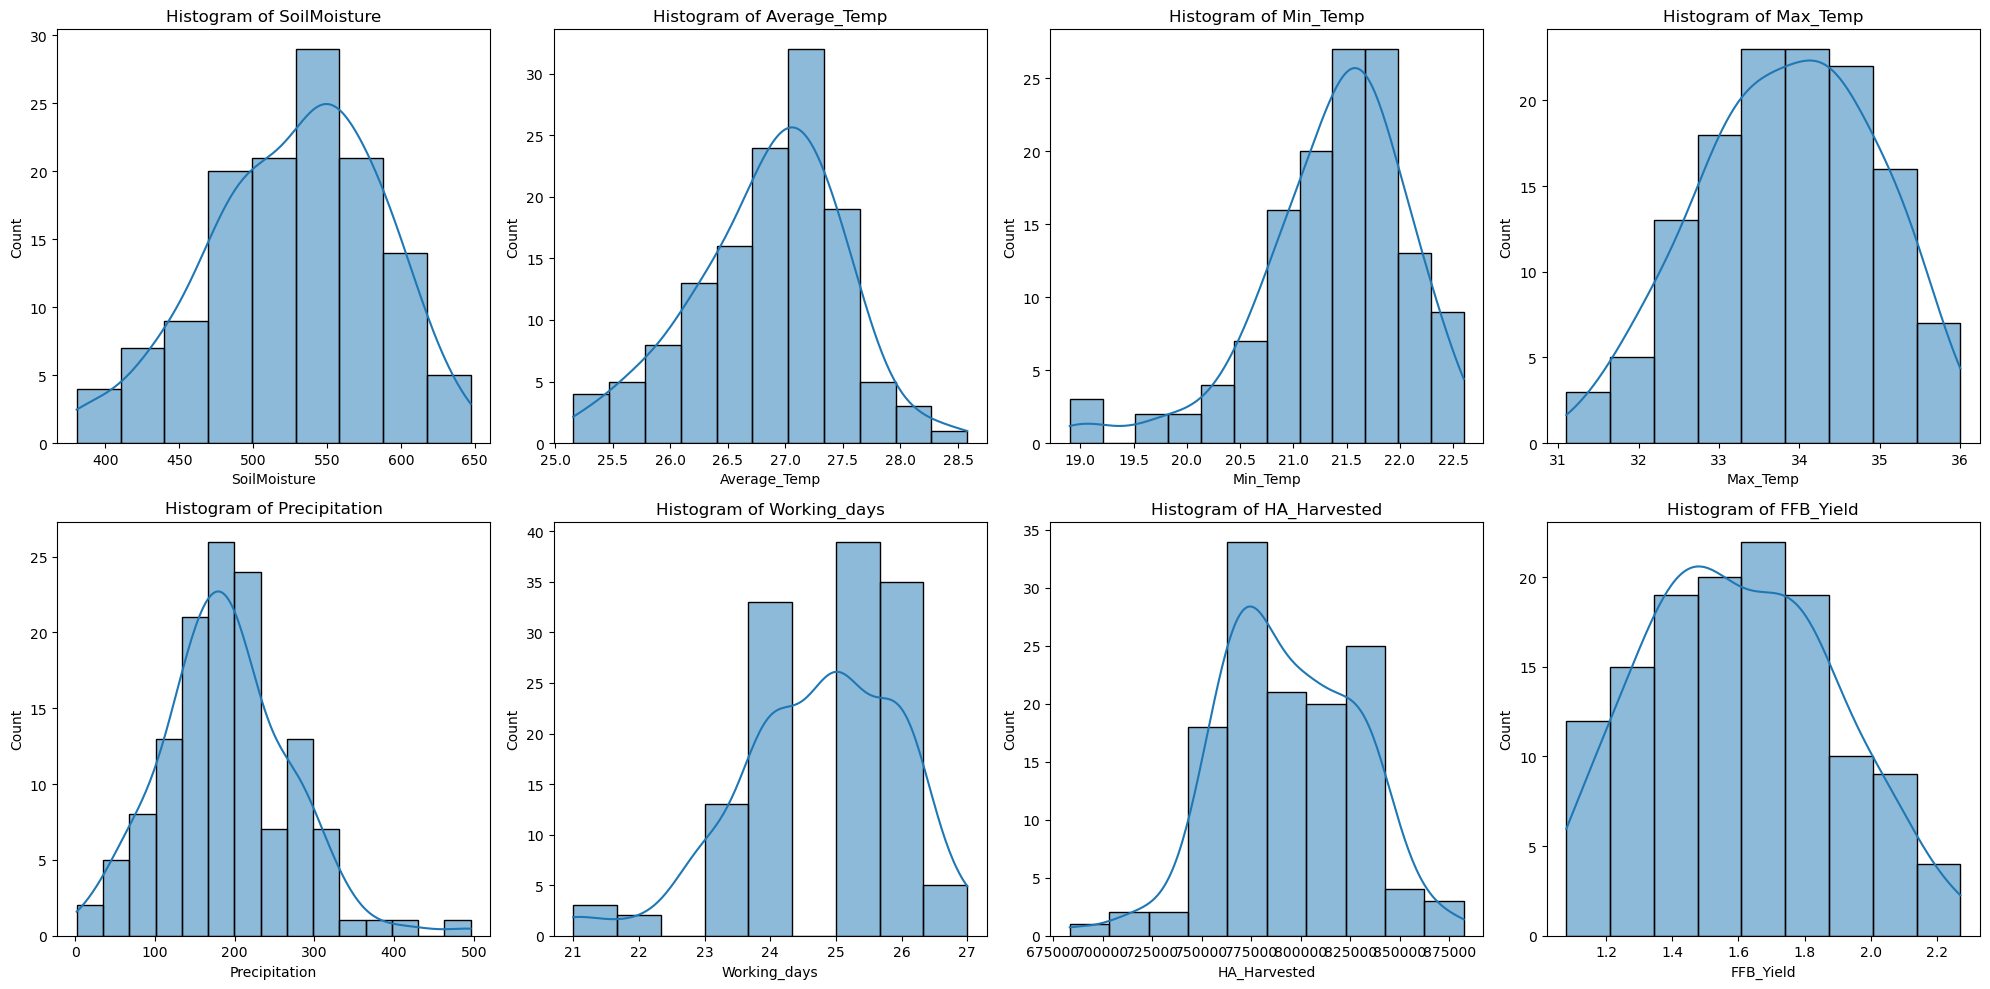

In [29]:
# Graphical analysis 
plt.figure(figsize=(20, 10))

# Excluding the 'Date' column from the columns to be plotted
columns_to_plot = [col for col in data.columns if col != 'Date']

for i, col in enumerate(columns_to_plot):
    plt.subplot(2, 4, i+1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()

##### 2.2 Boxplot for all column

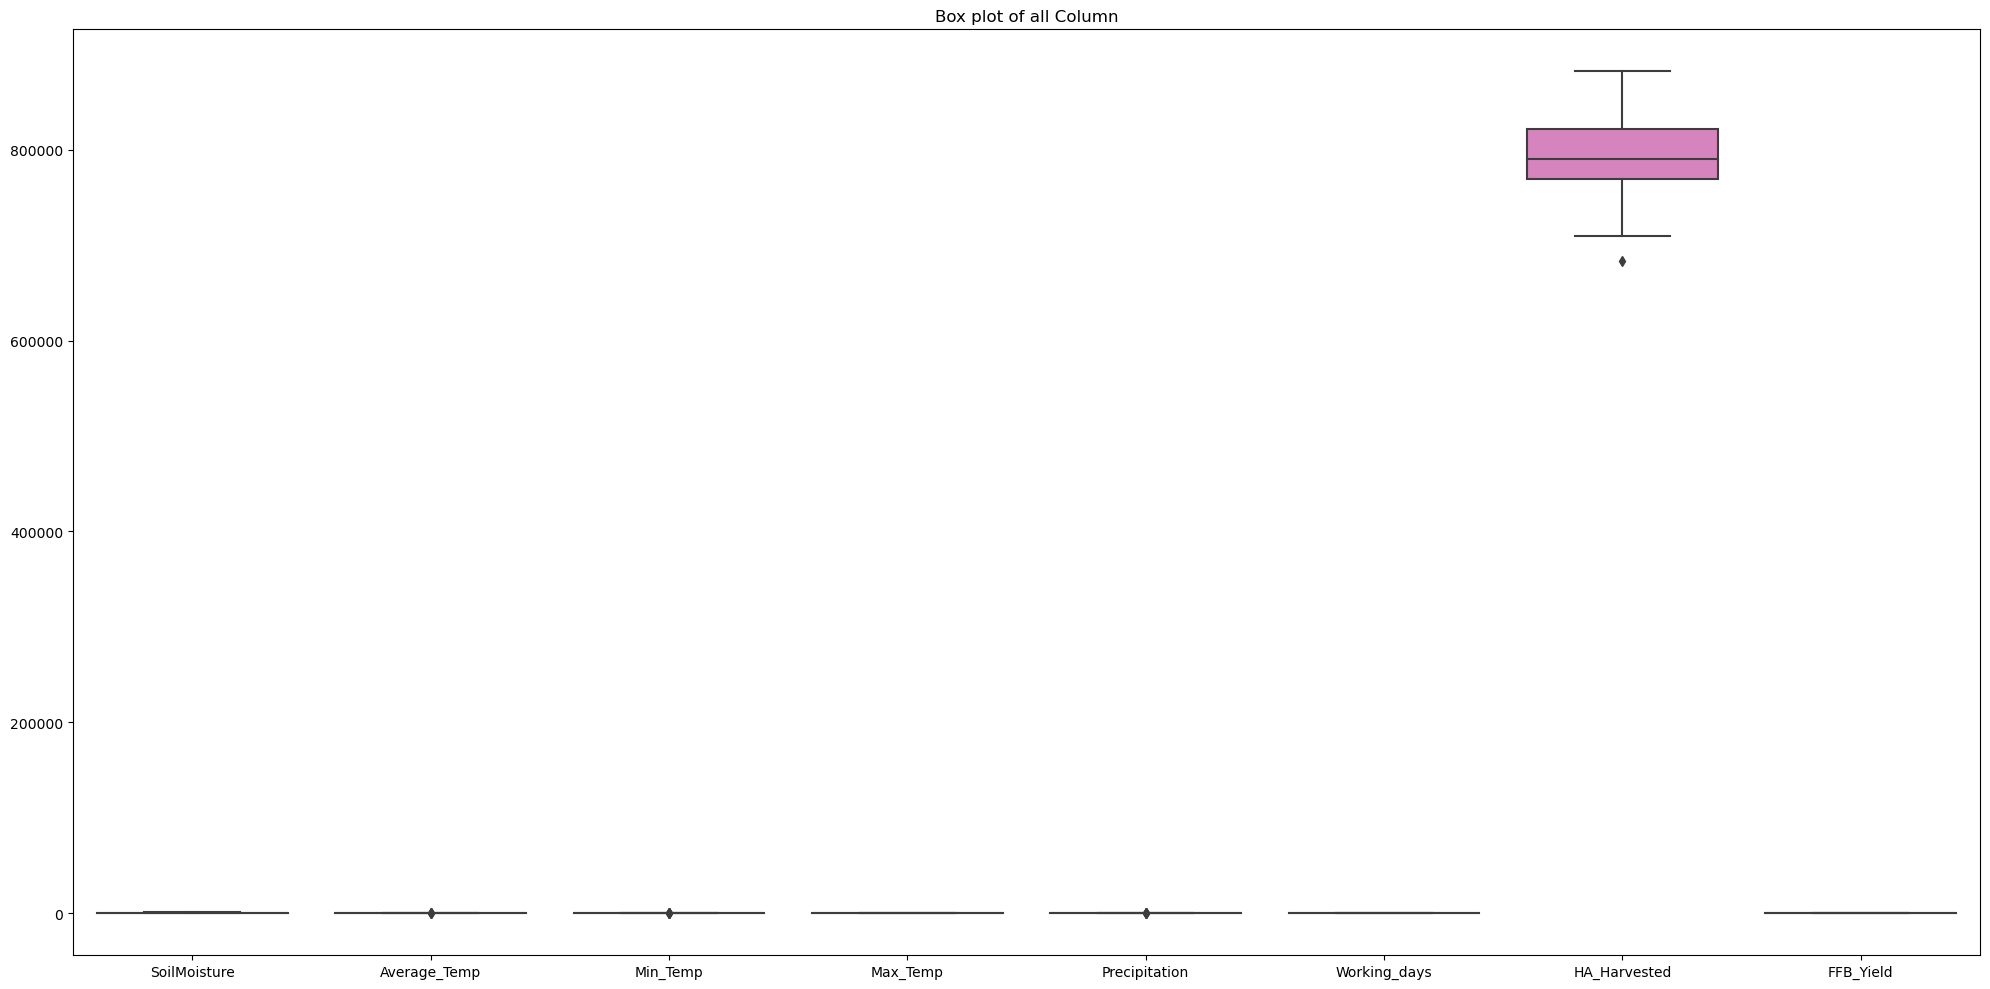

In [30]:
# Box plots
plt.figure(figsize=(20, 10))
sns.boxplot(data=data)
plt.title('Box plot of all Column')
plt.tight_layout()


##### 2.3 Boxplot for each individual column

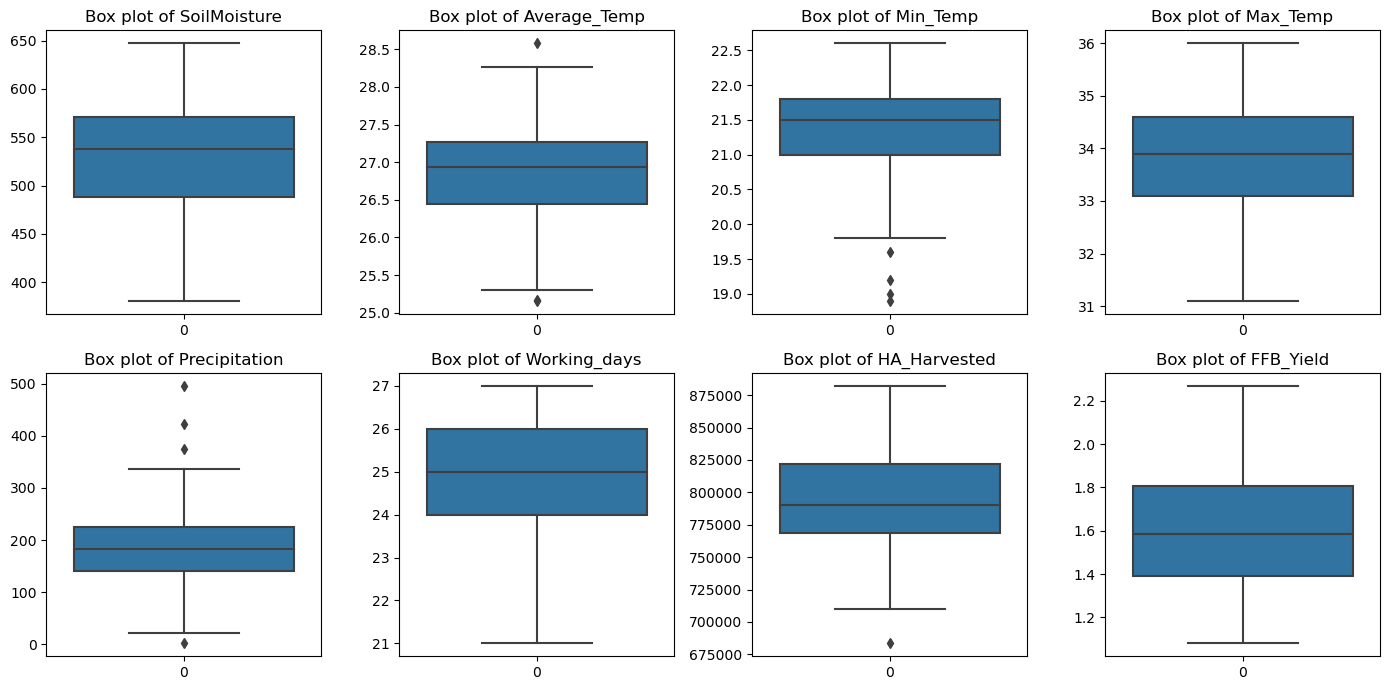

In [31]:
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Flatten the subplot array for easy iteration
axs = axs.flatten()

# Iterate over variables and create box plots
for i, var in enumerate(columns_to_plot):
    sns.boxplot(data=data[var], ax=axs[i])
    axs[i].set_title(f'Box plot of {var}')

# Adjust layout
plt.tight_layout()
plt.show()

##### 2.4 FFB Yield by Temperature Ranges

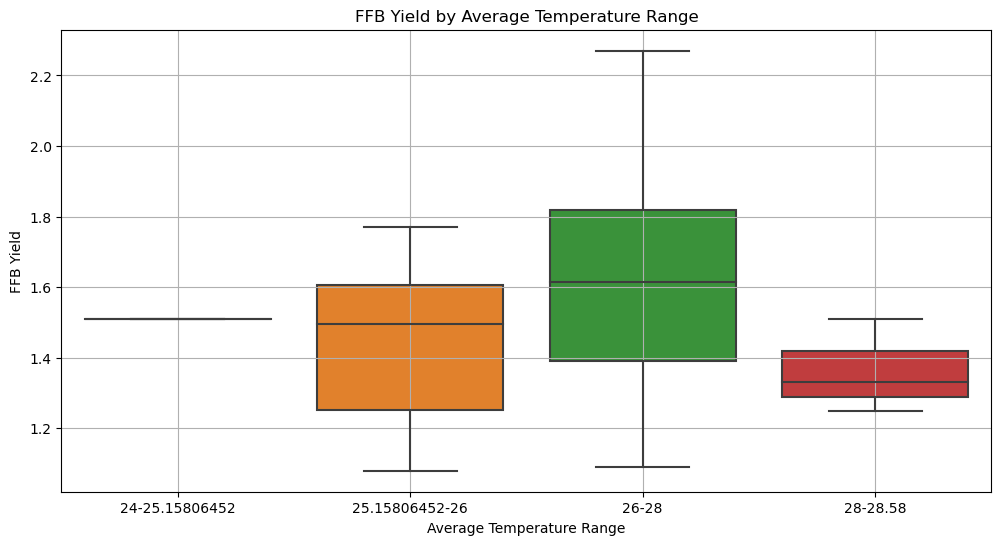

In [32]:
# Check the minimum and maximum values of Average_Temp to ensure proper binning
min_temp = data['Average_Temp'].min()
max_temp = data['Average_Temp'].max()

# Create a list of bin edges with monotonically increasing values
temperature_bins = [min_temp] + list(range(24, 29, 2)) + [max_temp]

# Ensure bins are monotonically increasing
temperature_bins = sorted(set(temperature_bins))

# Define labels for the bins. The number of labels should be one less than the number of bins
bin_labels = ['{0}-{1}'.format(temperature_bins[i], temperature_bins[i+1]) for i in range(len(temperature_bins)-1)]

# Create the bins
data['Temp_Range'] = pd.cut(data['Average_Temp'], bins=temperature_bins, labels=bin_labels, include_lowest=True)

# Create the box plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Temp_Range', y='FFB_Yield', data=data)
ax.set_title('FFB Yield by Average Temperature Range')
plt.xlabel('Average Temperature Range')
plt.ylabel('FFB Yield')
plt.grid(True)
plt.show()


In [33]:
data = data.drop('Temp_Range', axis= 1)

##### 2.4 Scatter Plot

###### 2.4.1 FFB Yield vs Each factor

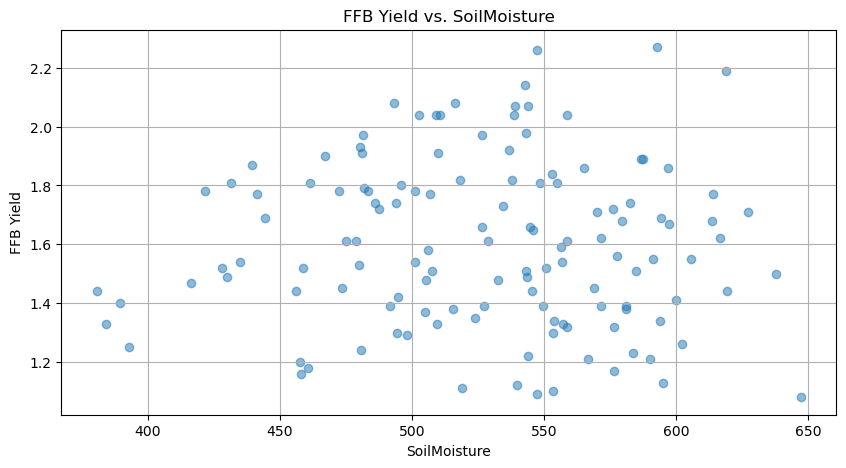

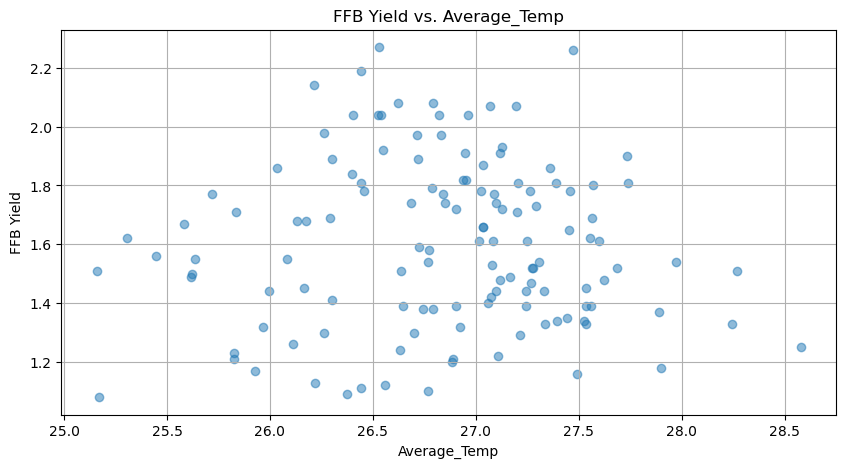

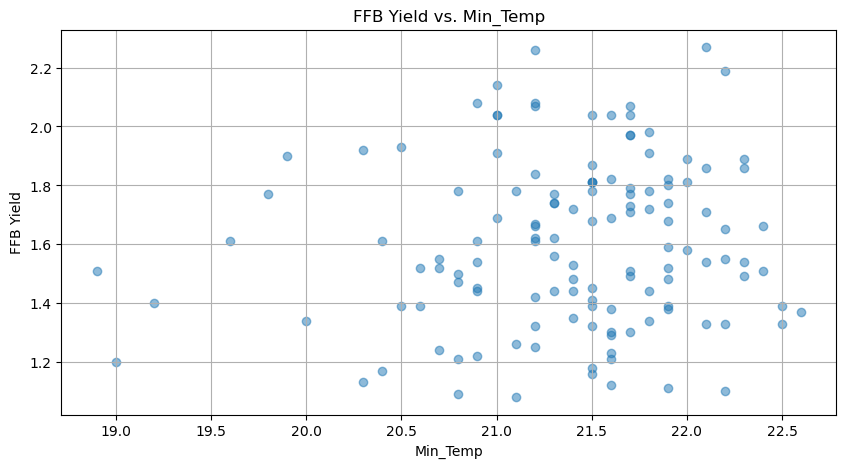

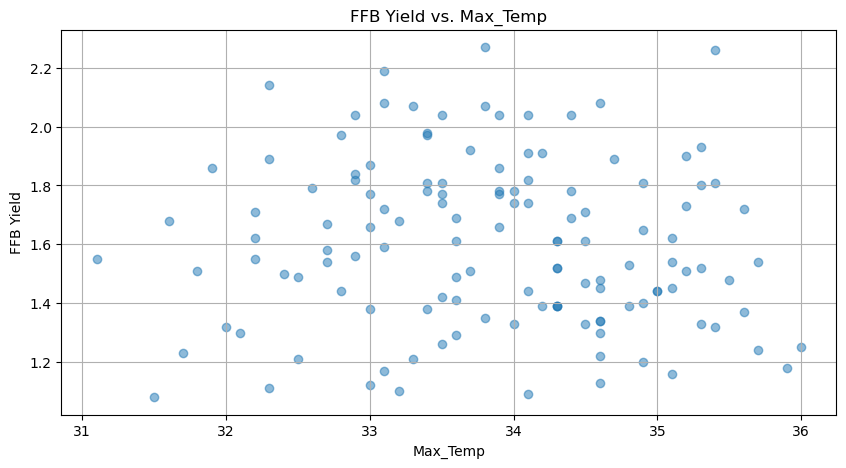

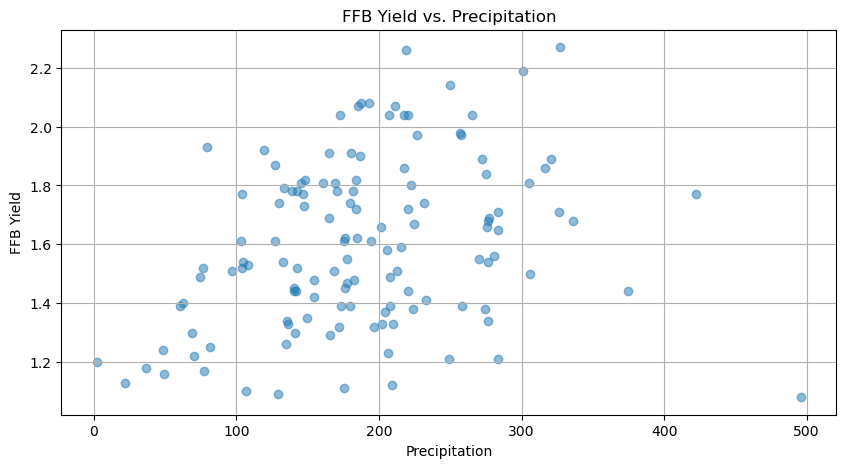

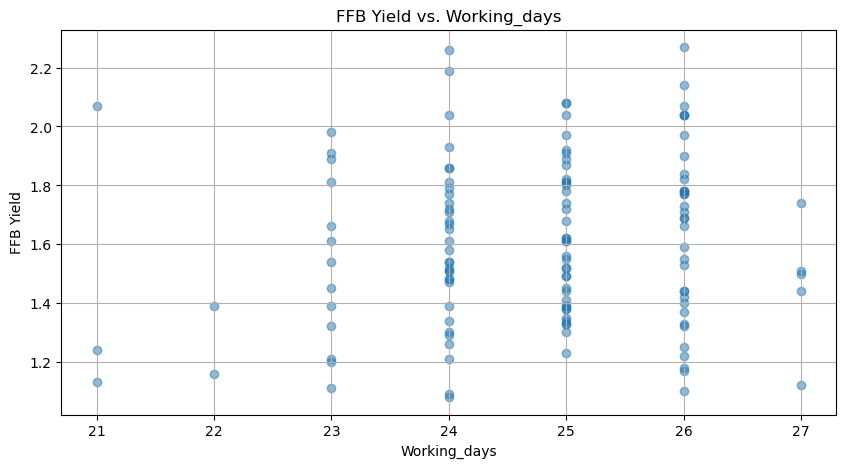

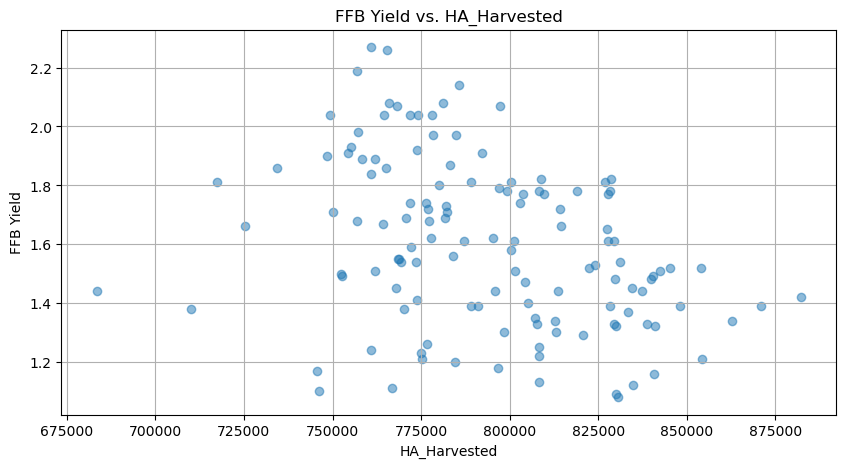

In [34]:
# List of factors to plot against FFB Yield
factors = ['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested']

# Create a scatter plot for each factor
for factor in factors:
    plt.figure(figsize=(10, 5))  # Adjust figure size
    plt.scatter(data[factor], data['FFB_Yield'], alpha=0.5)  # Create scatter plot
    plt.title(f'FFB Yield vs. {factor}')  # Title of the plot
    plt.xlabel(factor)  # X-axis label
    plt.ylabel('FFB Yield')  # Y-axis label
    plt.grid(True)  # Add grid for better readability
    plt.show()  # Display the plot

###### 2.4.2 Temperature vs Precipitation

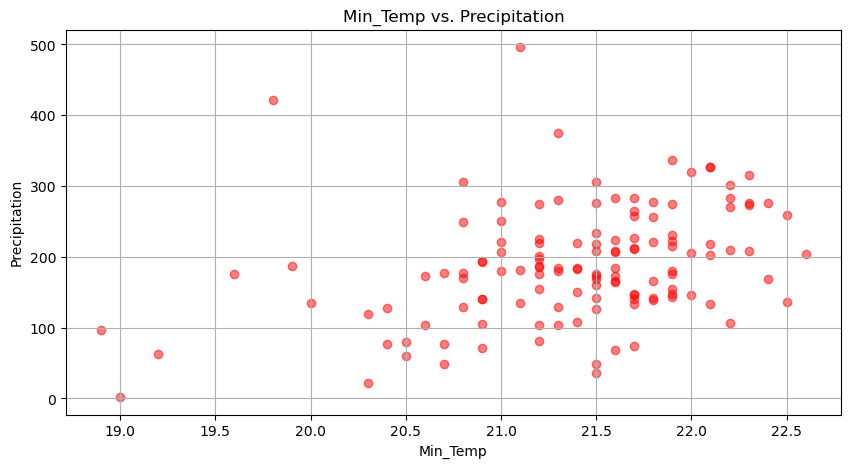

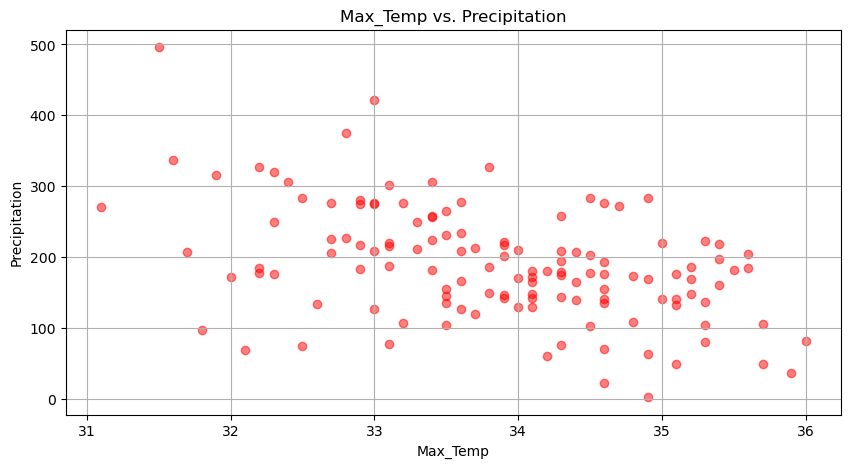

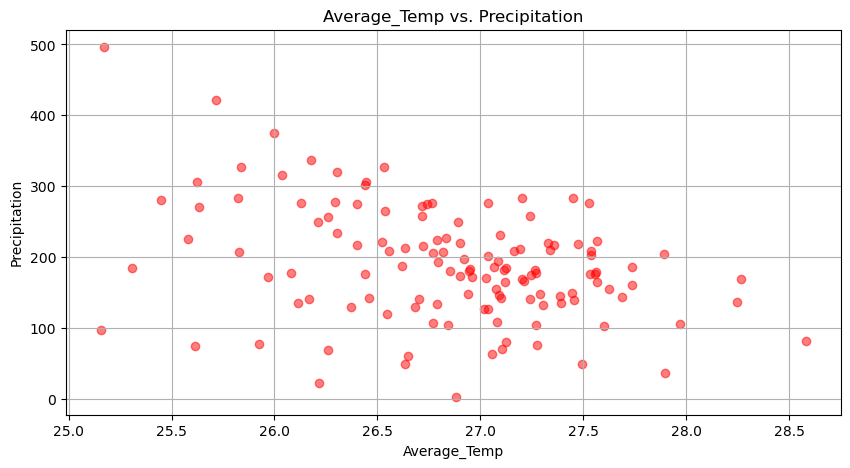

In [35]:
# Create a scatter plot for temperature types vs. precipitation
temperature_types = ['Min_Temp', 'Max_Temp', 'Average_Temp']

for temp in temperature_types:
    plt.figure(figsize=(10, 5))
    plt.scatter(data[temp], data['Precipitation'], alpha=0.5, color='r')  # Color red for visibility
    plt.title(f'{temp} vs. Precipitation')
    plt.xlabel(temp)
    plt.ylabel('Precipitation')
    plt.grid(True)
    plt.show()

In [36]:
# Convert to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

# Extract month data
data['Date_Month'] = data['Date'].dt.month


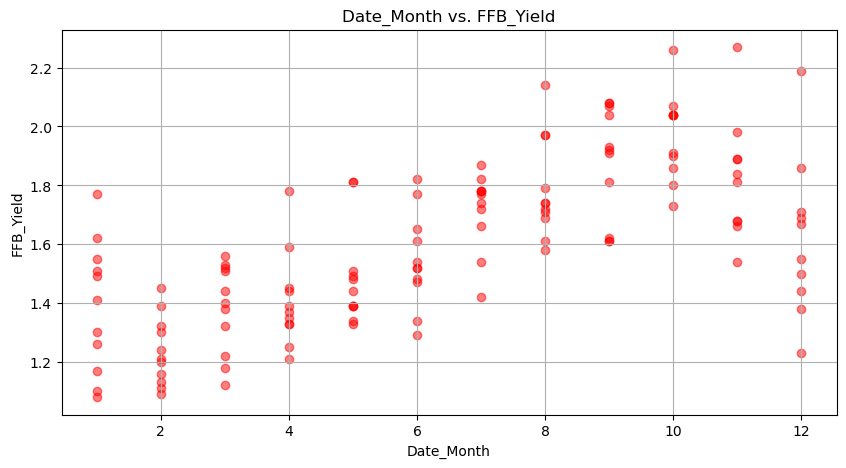

In [37]:

plt.figure(figsize=(10, 5))
plt.scatter(data['Date_Month'], data['FFB_Yield'], alpha=0.5, color='r')  # Color red for visibility
plt.title(f'Date_Month vs. FFB_Yield')
plt.xlabel('Date_Month')
plt.ylabel('FFB_Yield')
plt.grid(True)
plt.show()

In [38]:
data = data.drop('Date_Month', axis=1)

##### 3.0 Check for Normality

In [39]:
# Shapiro-Wilk Test for normality
data1 = data[[col for col in data.columns if col != 'Date']]
normality_results = {column: shapiro(data1[column]).pvalue for column in data1.columns}

normality_results

{'SoilMoisture': 0.0835467055439949,
 'Average_Temp': 0.136613130569458,
 'Min_Temp': 6.362040039675776e-06,
 'Max_Temp': 0.2031572163105011,
 'Precipitation': 0.0365123450756073,
 'Working_days': 3.607162000207609e-07,
 'HA_Harvested': 0.19249121844768524,
 'FFB_Yield': 0.09630227833986282}

##### 4. Correlation Matrix

In [40]:
# Spearman correlation coefficient matrix
correlation_matrix = df.corr(method='spearman')
correlation_matrix

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
SoilMoisture,1.000000,-0.611158,0.008096,-0.465575,0.534844,-0.055768,-0.346520,-0.053962
Average_Temp,-0.611158,1.000000,0.150144,0.735619,-0.313273,0.063742,0.496968,-0.036249
Min_Temp,0.008096,0.150144,1.000000,-0.164203,0.368256,-0.010767,-0.016674,0.084286
Max_Temp,-0.465575,0.735619,-0.164203,1.000000,-0.427017,-0.025549,0.330195,-0.110524
Precipitation,0.534844,-0.313273,0.368256,-0.427017,1.000000,0.076471,-0.276535,0.311944
Working_days,-0.055768,0.063742,-0.010767,-0.025549,0.076471,1.000000,0.045001,0.099606
HA_Harvested,-0.346520,0.496968,-0.016674,0.330195,-0.276535,0.045001,1.000000,-0.385903
FFB_Yield,-0.053962,-0.036249,0.084286,-0.110524,0.311944,0.099606,-0.385903,1.000000


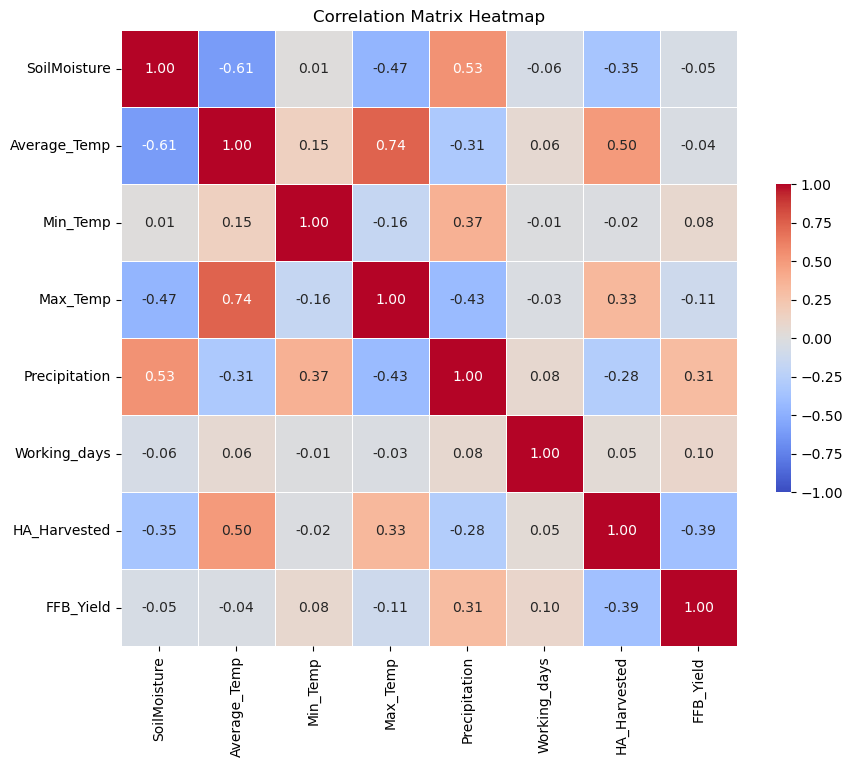

In [41]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Title and labels (optional)
plt.title('Correlation Matrix Heatmap')
plt.show()

##### 5. Time Series Plot

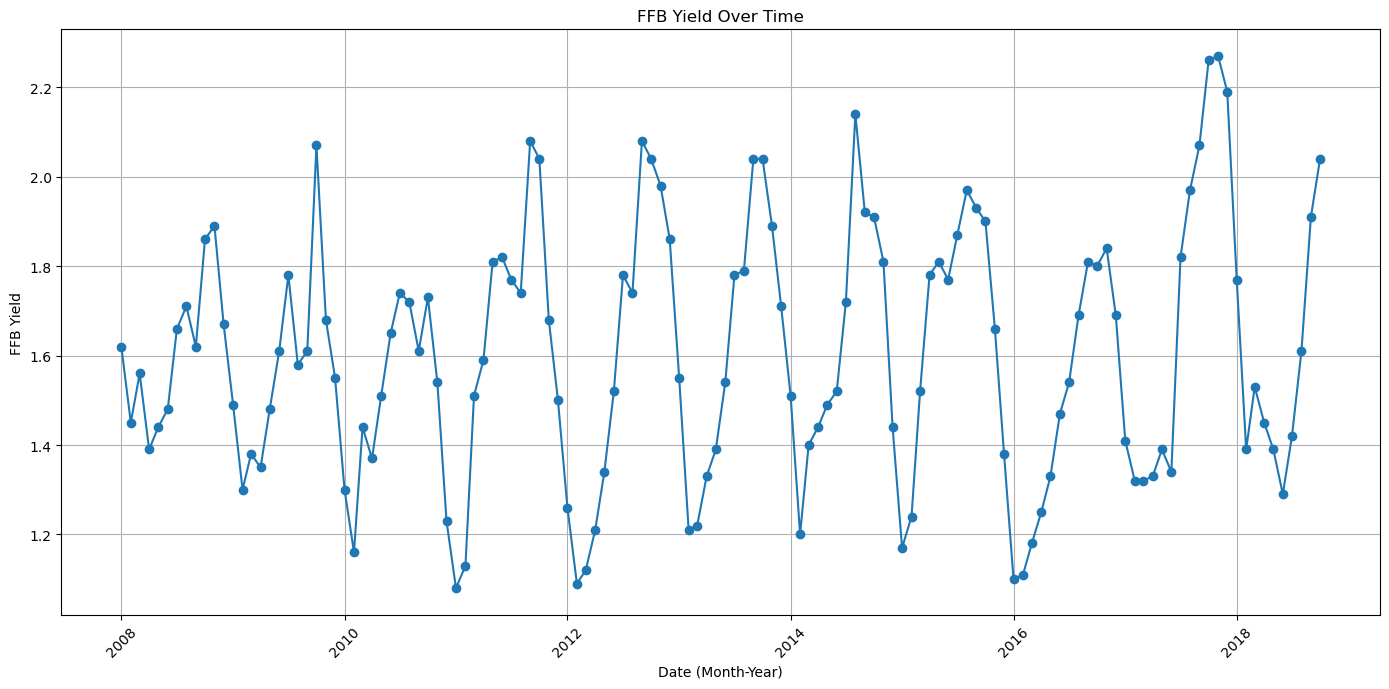

In [42]:
# Step 1: Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# Step 2: Simplify 'Date' to month and year format
df['YearMonth'] = df['Date'].dt.to_period('M')

# Step 3: Plotting the time series graph
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df['YearMonth'].dt.to_timestamp(), df['FFB_Yield'], marker='o', linestyle='-')
plt.title('FFB Yield Over Time')
plt.xlabel('Date (Month-Year)')
plt.ylabel('FFB Yield')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


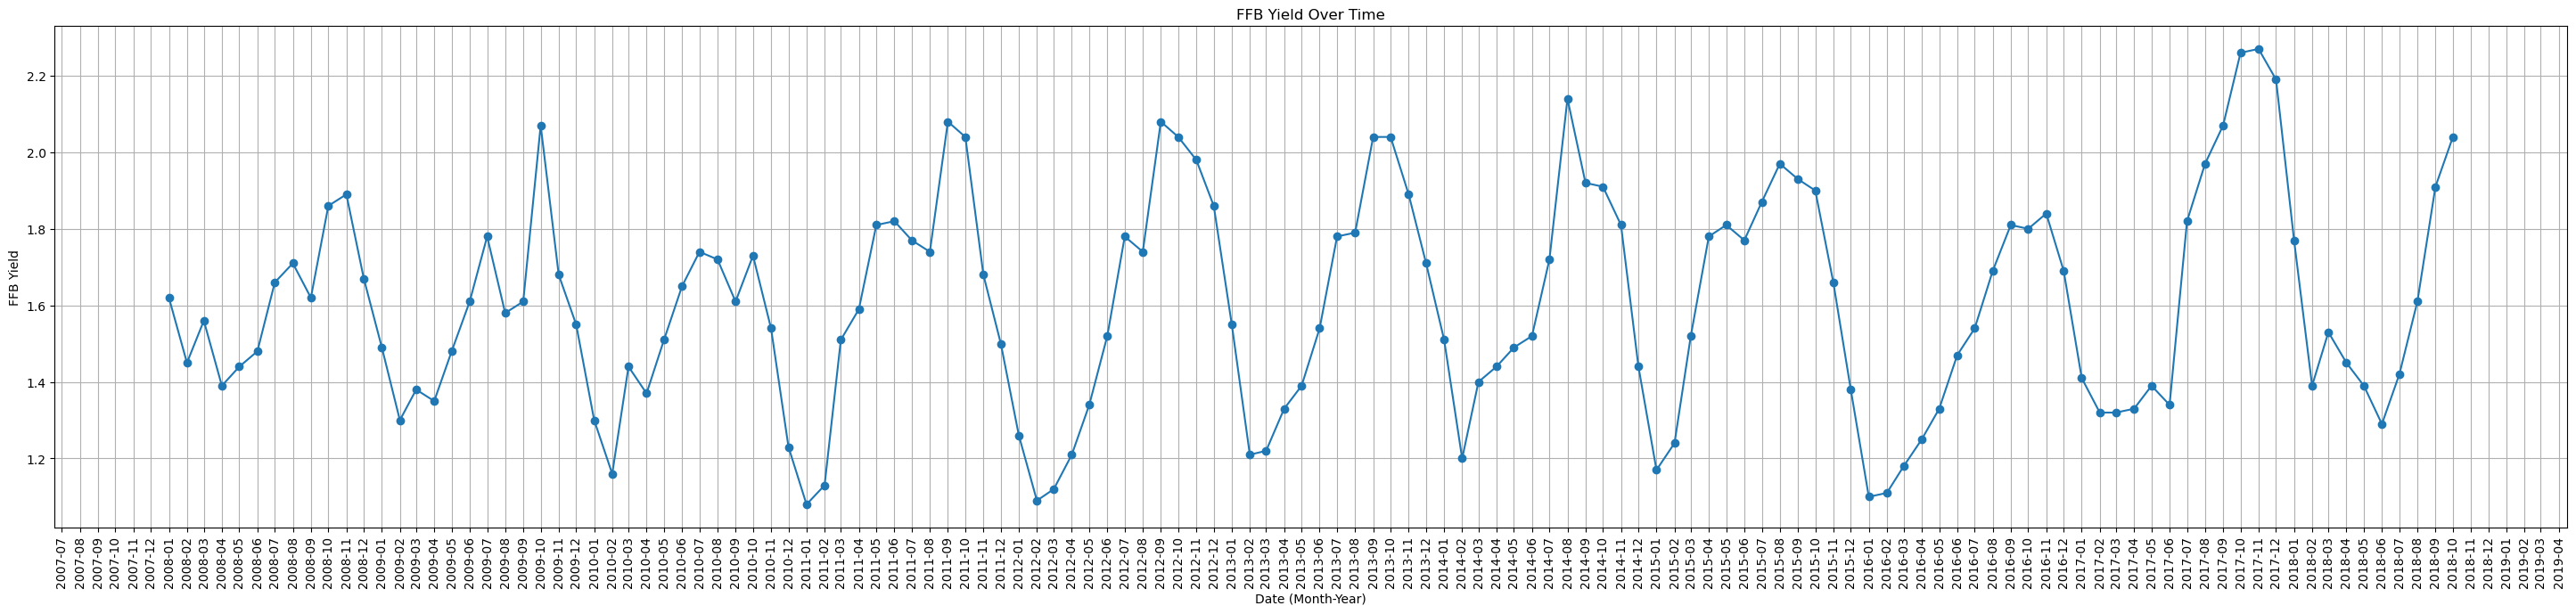

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(29, 7))
plt.plot(df['YearMonth'].dt.to_timestamp(), df['FFB_Yield'], marker='o', linestyle='-')
plt.title('FFB Yield Over Time')
plt.xlabel('Date (Month-Year)')
plt.ylabel('FFB Yield')
plt.grid(True)

# Setting x-ticks to display every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=90)  # Rotating the dates for better readability
plt.tight_layout()

# Show the plot
plt.show()


##### 6. Density Plot

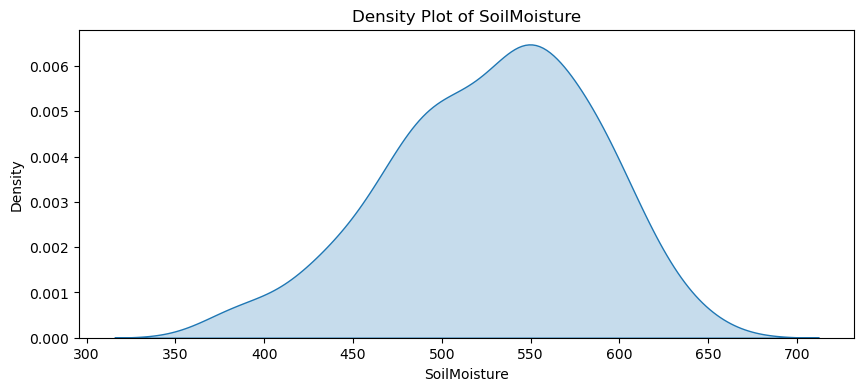

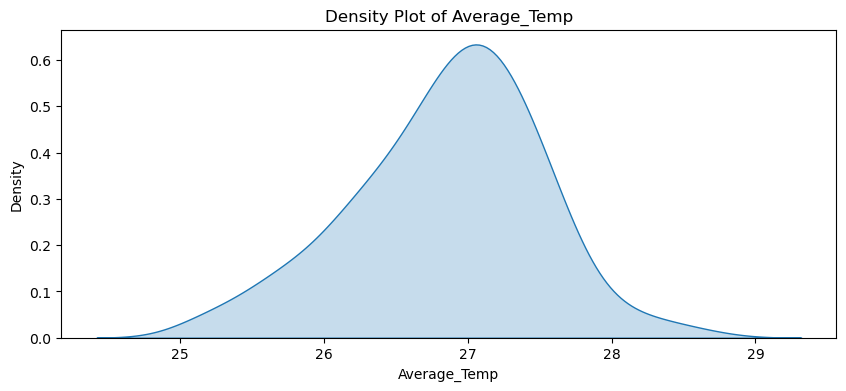

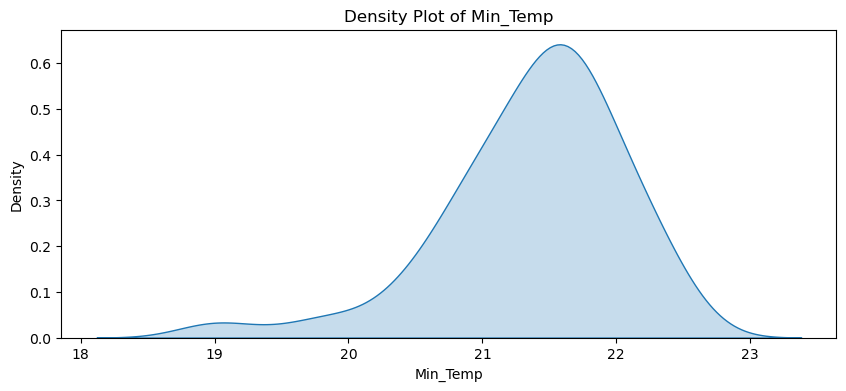

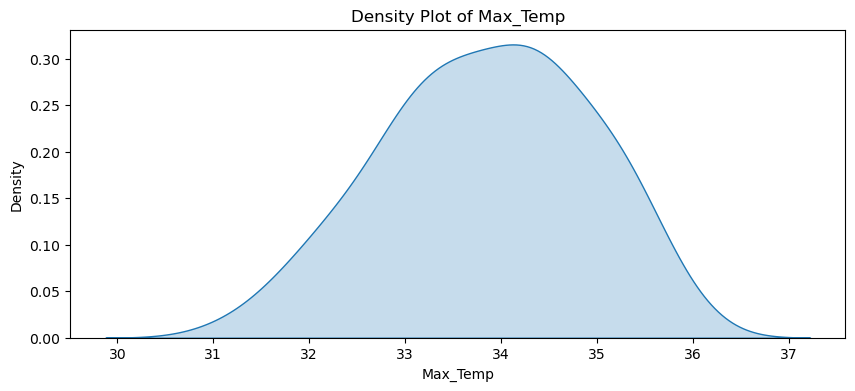

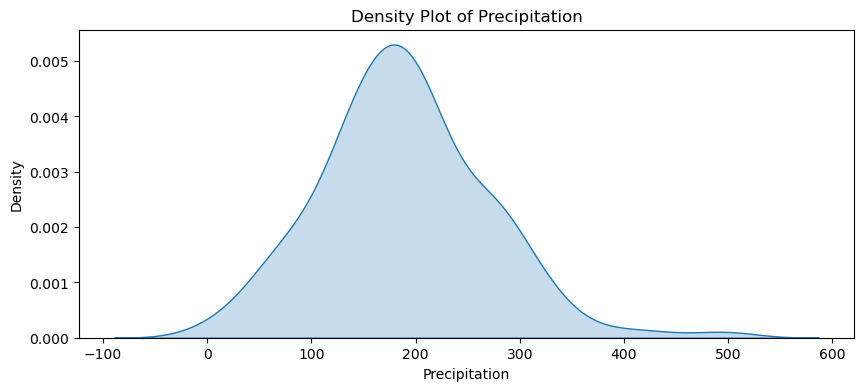

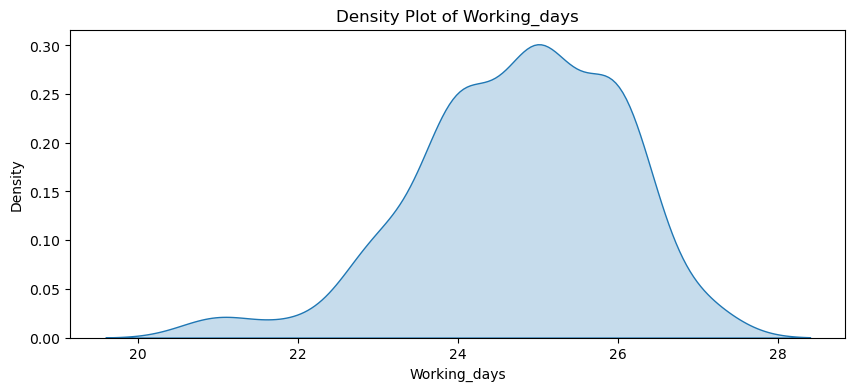

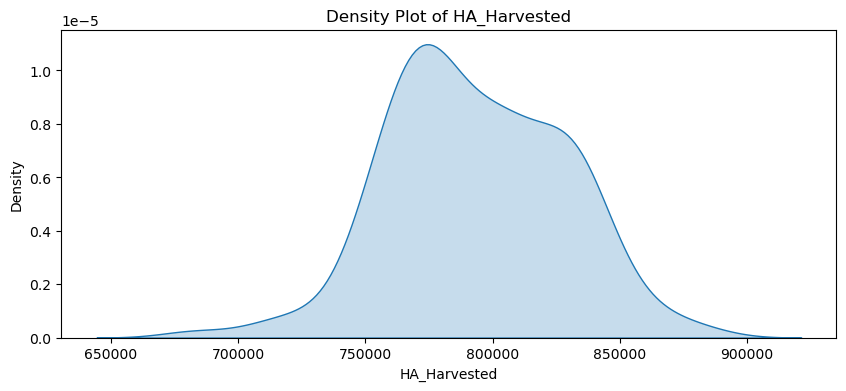

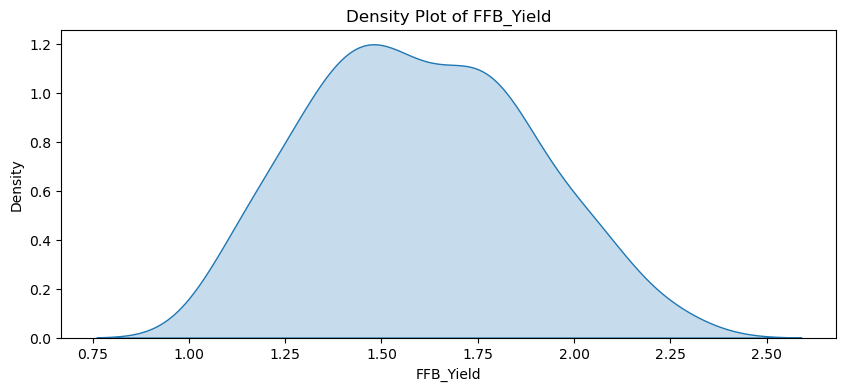

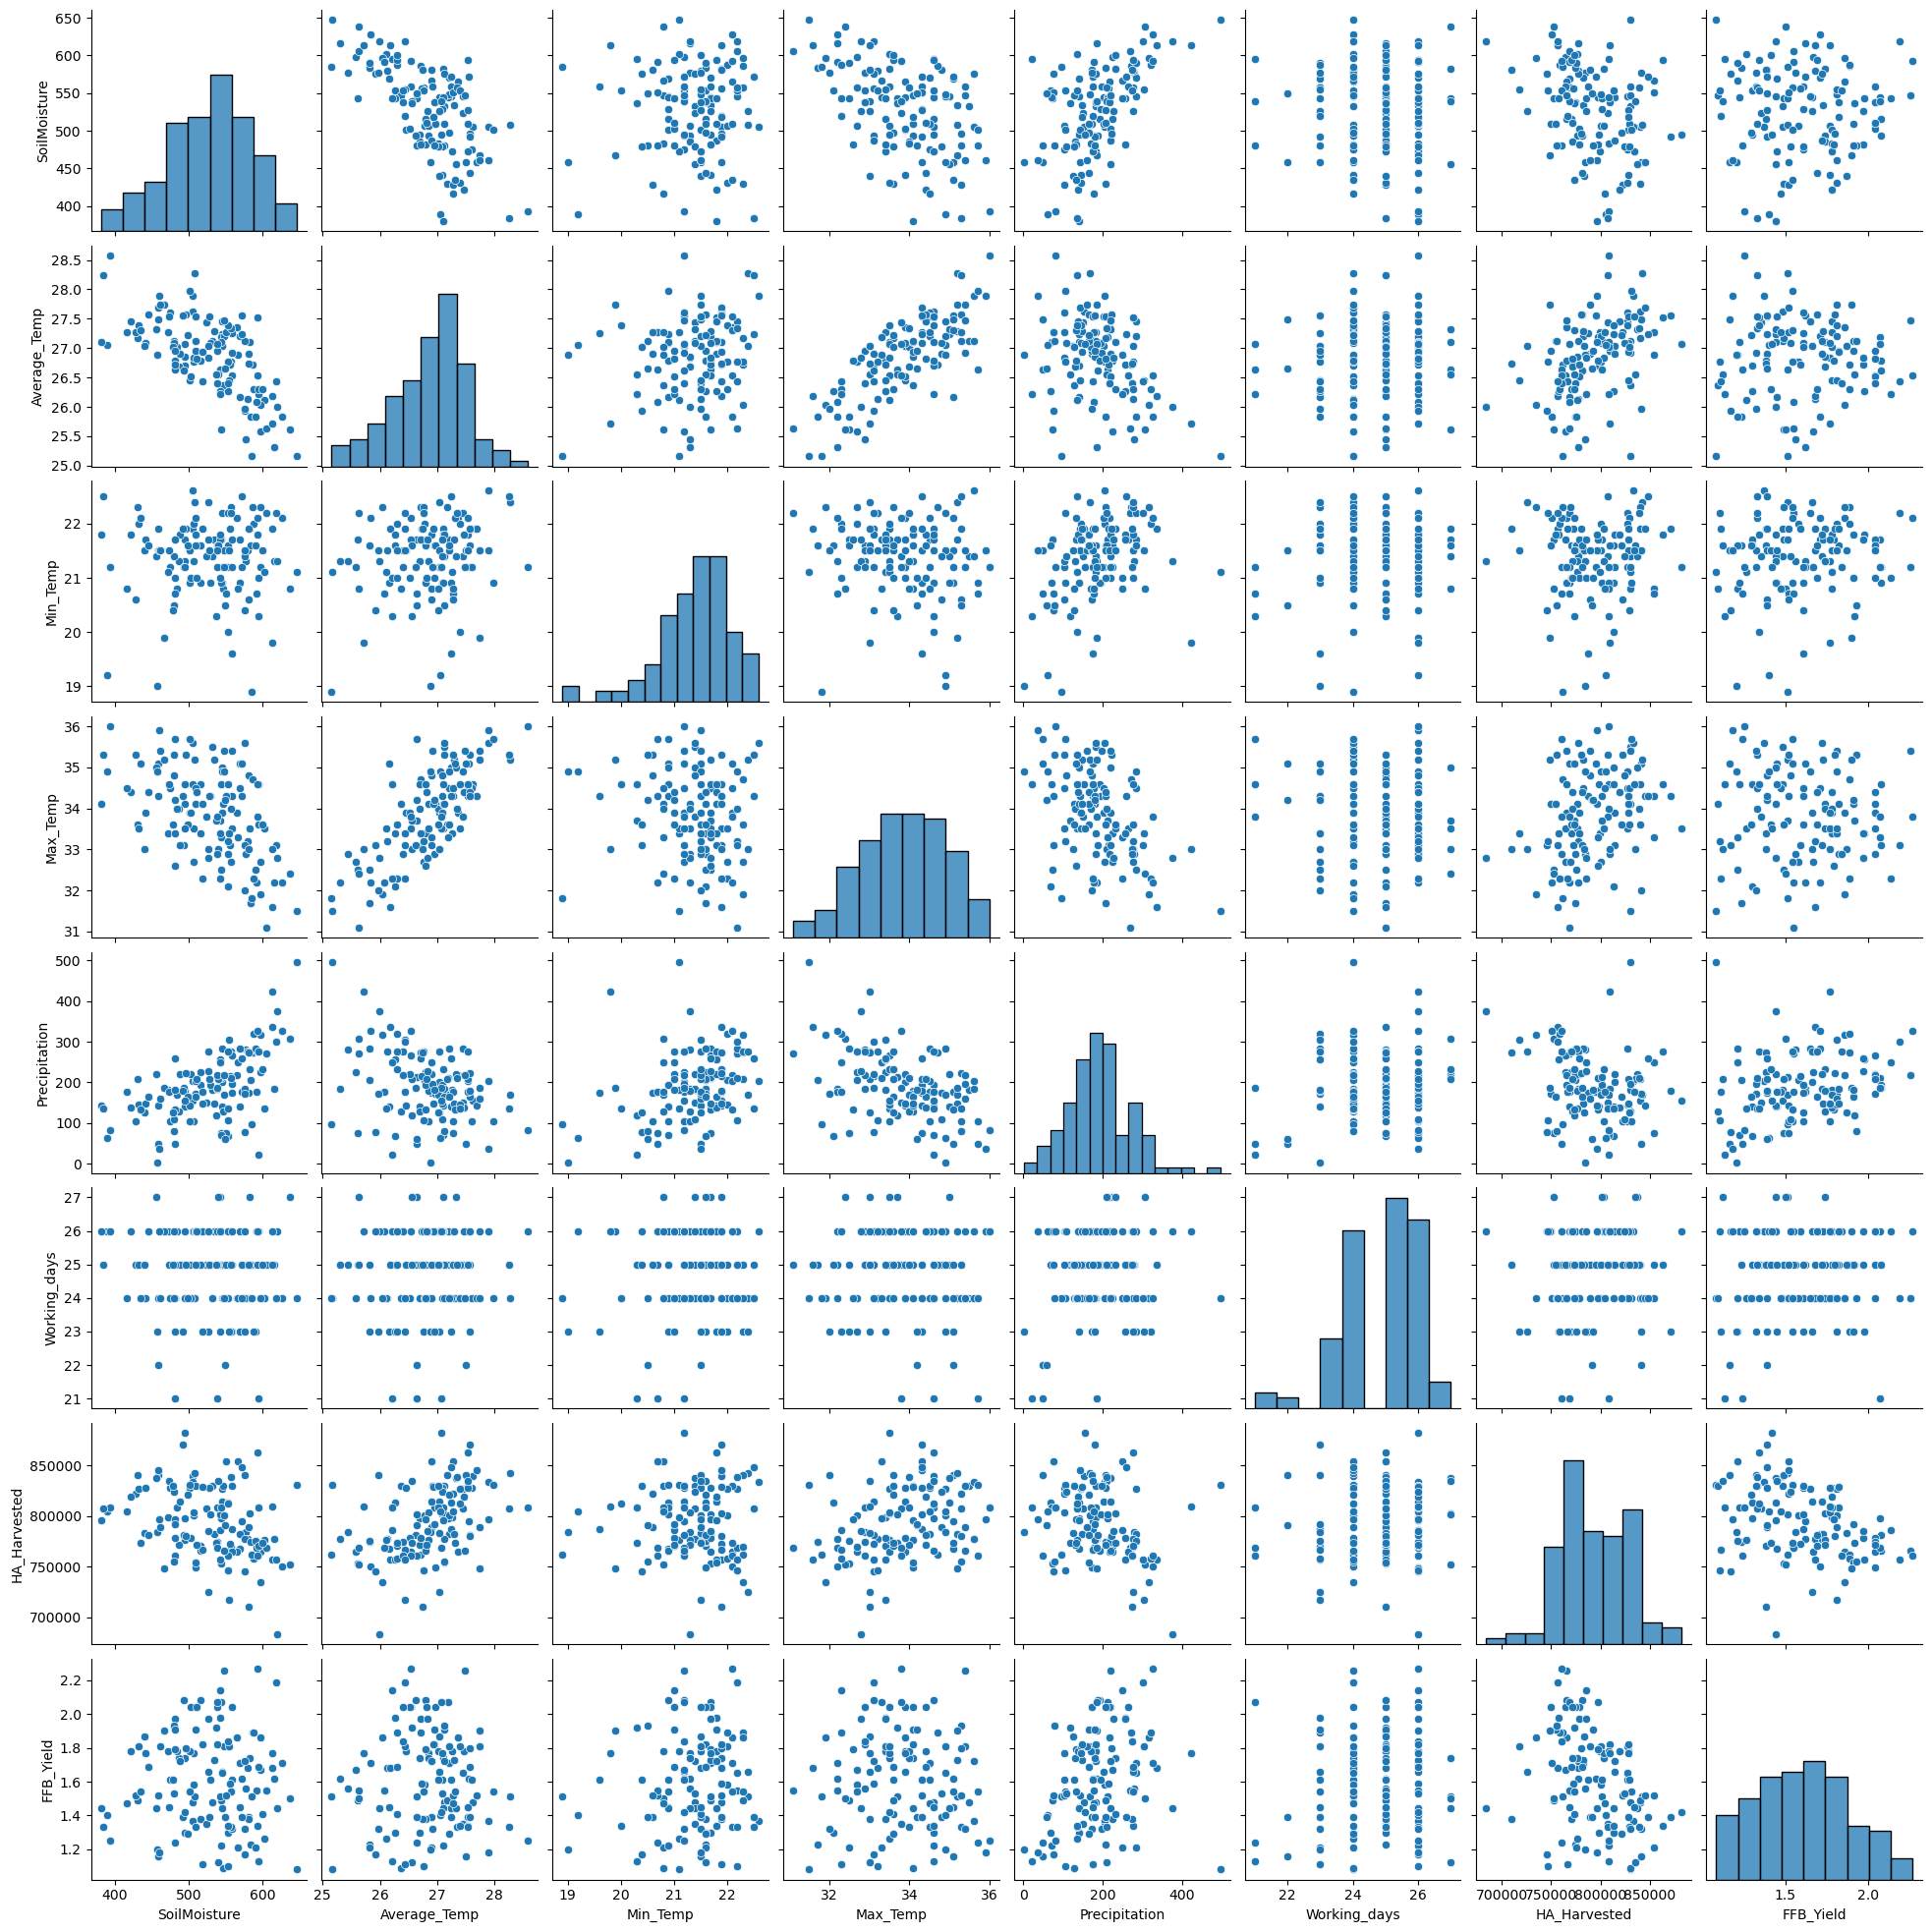

In [44]:

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Density Plots for each variable in the dataframe
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(df[column], shade=True)
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

# Pair Plot for the dataframe
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.show()

##### 7.0 Model

In [45]:
# Convert to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

# Extract month data
data['Date_Month'] = data['Date'].dt.month

# Use pandas get_dummies to one-hot encode 'Date_Month'
data = pd.get_dummies(data, columns=['Date_Month'], prefix='Month')

In [48]:
# List of columns to scale
columns_to_scale = ['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested']

# Standardize the features of input features
scaler = StandardScaler()
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

X = data.drop(['Date', 'FFB_Yield'], axis=1)
y = df['FFB_Yield'].values  # you can also use df_encoded['FFB_Yield'].values; both should be the same.

# Split the data into training and testing sets for validation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###### 7.1 Base Model 

In [49]:
rf = RandomForestRegressor(random_state=42)
gb_model  = GradientBoostingRegressor(random_state=42)
lr_model = LinearRegression()
ridge_model = Ridge(random_state=42)

models = {
    "Linear Regression": lr_model,
    "Ridge Regression": ridge_model,
    "Lasso Regression": Lasso(random_state=42),
    "Random Forest": rf,
    "Gradient Boosting": gb_model,
    "XGBRegressor": xgb.XGBRegressor(random_state=42)
}

In [50]:
# Function to train and evaluate a model
def train_evaluate(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Print results
        results[name] = (mse, r2)
    
    return results


In [51]:
# Train and evaluate all models
results = train_evaluate(models, X_train, y_train, X_test, y_test)

sorted_results = sorted(results.items(), key=lambda item: item[1][0])
for name, metrics in sorted_results:
    print(f"{name} - MSE: {metrics[0]:.4f}, R2: {metrics[1]:.4f}")

Gradient Boosting - MSE: 0.0307, R2: 0.6463
Linear Regression - MSE: 0.0319, R2: 0.6329
Ridge Regression - MSE: 0.0348, R2: 0.5991
Random Forest - MSE: 0.0396, R2: 0.5435
XGBRegressor - MSE: 0.0480, R2: 0.4468
Lasso Regression - MSE: 0.0896, R2: -0.0317


###### 7.2 Gradient Boosting Hyperparameter

In [52]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor

# Define the base model
base_model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Define the cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}


###### 7.2.1 Gradient Boosting Result (Hyperparameter)

In [53]:
# Evaluate the best model on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics (e.g., MSE, R-squared)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Evaluation Metrics:")
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Evaluation Metrics:
Mean Squared Error: 0.032344589070270886
R-squared: 0.6276032126609602


###### 7.3 Linear Regression Hyperparameter

In [54]:

# Define the base model
base_model = LinearRegression()

# Define the hyperparameters grid
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameters: {'fit_intercept': False, 'normalize': True}


In [55]:
# Evaluate the best model on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics (e.g., MSE, R-squared)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Evaluation Metrics:")
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Evaluation Metrics:
Mean Squared Error: 0.03188528118747674
R-squared: 0.6328914164956241


###### 7.4 Ridge Regression Hyperparameter

In [56]:
# Define the base model
base_model = Ridge()

# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'alpha': 0.1, 'fit_intercept': True, 'normalize': True}


In [57]:
# Evaluate the best model on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics (e.g., MSE, R-squared)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Evaluation Metrics:")
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Evaluation Metrics:
Mean Squared Error: 0.03362319727622871
R-squared: 0.6128820614004029


###### 7.5 Random Forest Hyperparameter

In [58]:

# Define the base model
base_model = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


In [59]:
# Evaluate the best model on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics (e.g., MSE, R-squared)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Evaluation Metrics for Random Forest:")
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Evaluation Metrics for Random Forest:
Mean Squared Error: 0.04106055391306418
R-squared: 0.5272526625592254


###### 7.6 Feature Importance in Random Forest

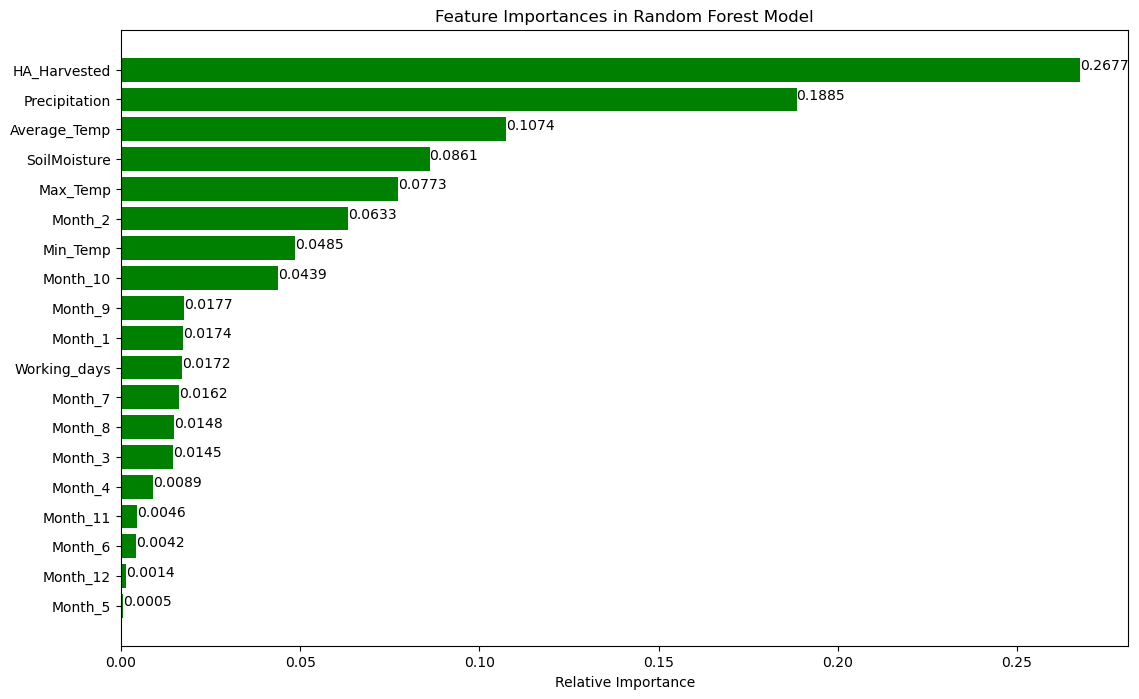

In [60]:
# Assuming 'rf_model' is your trained Random Forest model from earlier
feature_importances = rf.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

# Create a bar chart
plt.figure(figsize=(13, 8))
plt.title('Feature Importances in Random Forest Model')
plt.barh(range(len(indices)), feature_importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

# Add the importance values on the bars
for i in range(len(indices)):
    plt.text(feature_importances[indices[i]], i, f"{feature_importances[indices[i]]:.4f}")

plt.show()


###### 7.7 Feautre Importance in Gradient Boosting

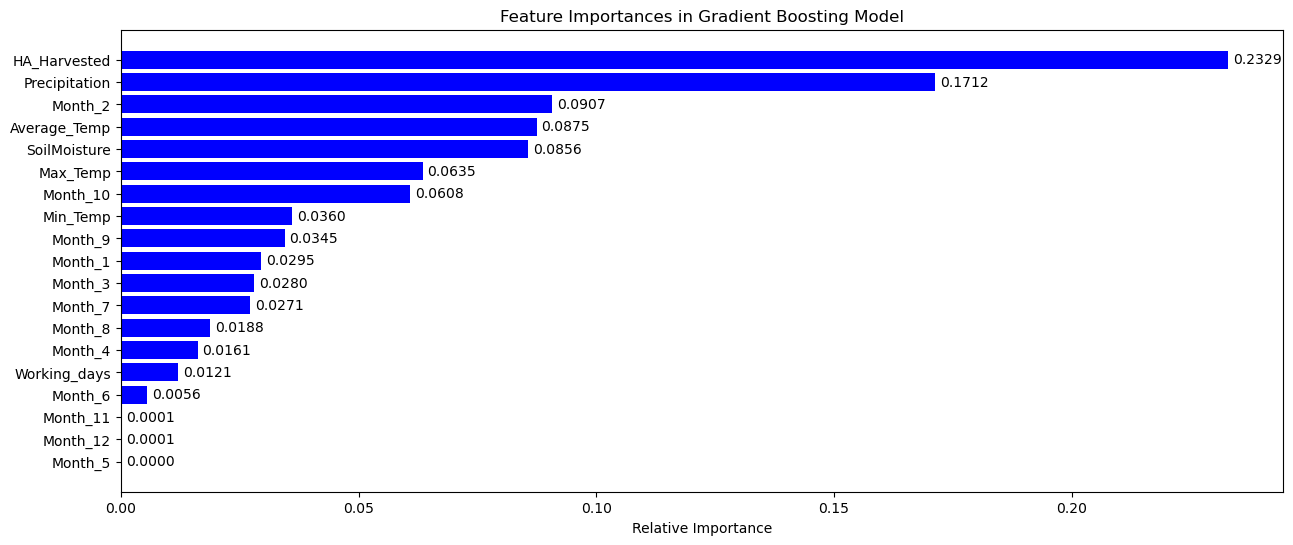

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'gb_model' is your trained Gradient Boosting model
gb_feature_importances = gb_model.feature_importances_
features = X.columns
indices = np.argsort(gb_feature_importances)

plt.figure(figsize=(15, 6))
plt.title('Feature Importances in Gradient Boosting Model')
bars = plt.barh(range(len(indices)), gb_feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

# Add the importance values on the bars
for bar, value in zip(bars, gb_feature_importances[indices]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f"{value:.4f}", va='center')

plt.show()


###### 7.8 Feature Importance in Linear/Ridge Regression

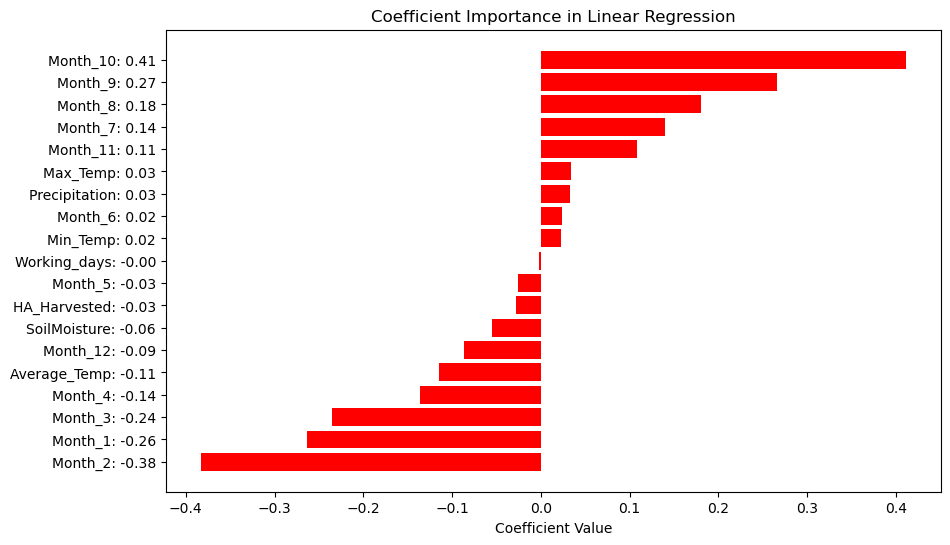

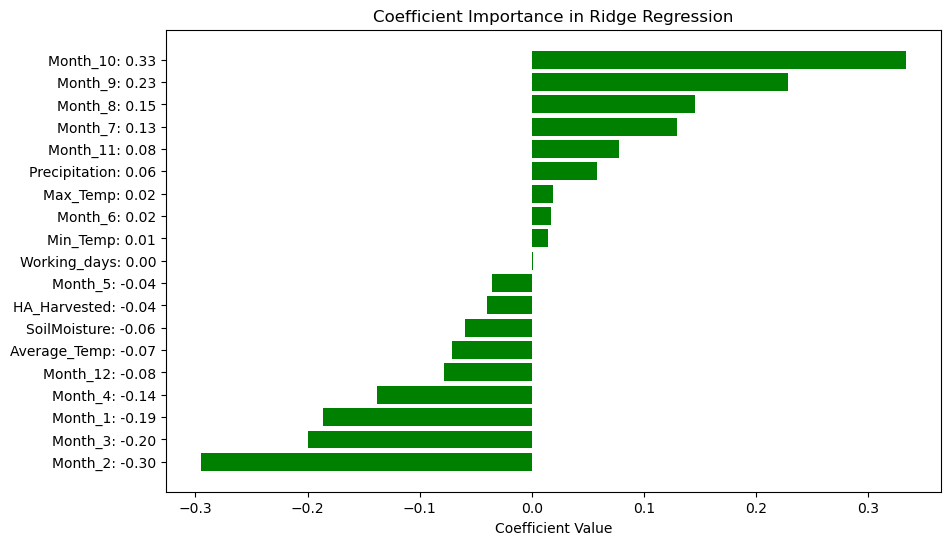

In [62]:
# For Linear Regression Coefficients
lr_coefficients = lr_model.coef_
lr_indices = np.argsort(lr_coefficients)
plt.figure(figsize=(10, 6))
plt.title('Coefficient Importance in Linear Regression')
plt.barh(range(len(lr_indices)), lr_coefficients[lr_indices], color='r', align='center')
plt.yticks(range(len(lr_indices)), [f"{features[i]}: {lr_coefficients[i]:.2f}" for i in lr_indices])
plt.xlabel('Coefficient Value')
plt.show()

# For Ridge Regression Coefficients
ridge_coefficients = ridge_model.coef_
ridge_indices = np.argsort(ridge_coefficients)
plt.figure(figsize=(10, 6))
plt.title('Coefficient Importance in Ridge Regression')
plt.barh(range(len(ridge_indices)), ridge_coefficients[ridge_indices], color='g', align='center')
plt.yticks(range(len(ridge_indices)), [f"{features[i]}: {ridge_coefficients[i]:.2f}" for i in ridge_indices])
plt.xlabel('Coefficient Value')
plt.show()


# 

In [63]:

# Initialize individual regressors
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
xgbr = xgb.XGBRegressor(random_state=42)

# Create an averaging ensemble regressor
averaging_ensemble = VotingRegressor(
    estimators=[
        ('rf', rf),
        ('gb', gb),
        ('xgbr', xgbr)
    ])

# Train the ensemble
averaging_ensemble.fit(X_train, y_train)

# Evaluate the ensemble
y_pred_ensemble = averaging_ensemble.predict(X_test)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Averaging Ensemble MSE: {mse_ensemble:.4f}")
print(f"Averaging Ensemble R2: {r2_ensemble:.4f}")


Averaging Ensemble MSE: 0.0355
Averaging Ensemble R2: 0.5915


In [64]:
from sklearn.ensemble import StackingRegressor

# Define the base learners
base_learners = [
    ('rf', rf),
    ('gb', gb),
    ('xgbr', xgbr)
]

# Initialize stacking ensemble
stacking_ensemble = StackingRegressor(
    estimators=base_learners, final_estimator=Ridge(random_state=42))

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Evaluate the stacking ensemble
y_pred_stack = stacking_ensemble.predict(X_test)
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Ensemble MSE: {mse_stack:.4f}")
print(f"Stacking Ensemble R2: {r2_stack:.4f}")


Stacking Ensemble MSE: 0.0392
Stacking Ensemble R2: 0.5486
